# Optimizing Factor Portfolios with Hierarchical Clustering

This notebook aims to investigate how hierarchical clustering algorithms categorize factor portfolios. Traditionally, these factors are grouped into broader categories like 'Momentum,' 'Seasonality,' 'Short-Term Reversal,' 'Size,' and 'Value.' 

We will examine whether these established clusters are consistently identified and whether diversifying across all factors can enhance the performance of an equally weighted factor-based portfolio.

## Load libraries

In [1]:
import os
import sys

os.chdir("../..")

cwd = os.getcwd()

for root, dirs, file in os.walk(cwd):
    sys.path.append(root)

In [2]:
cwd

'c:\\Users\\HP\\Desktop\\Work\\Projects\\factor_investing'

In [3]:
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go


from scipy.cluster.hierarchy import (
    linkage,
    dendrogram,
    optimal_leaf_ordering,
    leaves_list,
    fcluster,
)

In [4]:
from utils import set_layout

In [5]:
%load_ext autoreload
%autoreload 2

## Load Data

### Factors infos

In [6]:
PATH_TO_DATA_FACTOR_INFOS = "data/raw_data/factor_cluster_label.csv"

df_ptf_infos = (
    pl.read_csv(PATH_TO_DATA_FACTOR_INFOS).with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
        pl.col("available_date").str.to_date(format="%Y-%m-%d"),
    )
    # .rename({"portfolio": "name", "factor": "cluster"})
)

### Factors return

In [7]:
PATH_TO_DATA_FACTOR_RETURNS = "data/raw_data/us_factors_vw_daily.csv"

df_ptf_rets = (
    pl.read_csv(PATH_TO_DATA_FACTOR_RETURNS)
    .with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
    )
    .join(
        df_ptf_infos.select(["available_date", "portfolio", "factor"]), on="portfolio", how="left"
    )
)

## HC Study

### PLOT HIERARCHY

In [8]:
def compute_linkage(
    df_corr: pd.DataFrame,
    linkage_method: str = "ward",
):
    df_dist_cs = ((1 - df_corr) / 2) ** 0.5

    return linkage(df_dist_cs, linkage_method)


def get_hc_linkage_cluster(arr_linkage: list, nb_cluster: int) -> list:
    return fcluster(arr_linkage, nb_cluster, criterion="maxclust")

In [9]:
START_DATE = dt.date(1990, 1, 1)

DATES = (
    df_ptf_rets.filter(pl.col("date") > START_DATE)
    .select("date")
    .to_series()
    .unique()
    .sort()
    .to_list()
)
IDX_DATE = 5000
WINDOW = 2

LINKAGE_METHOD = "ward"


df_ptf_cs = df_ptf_rets.filter(
    pl.col("date").is_between(DATES[IDX_DATE] - dt.timedelta(weeks=4 * WINDOW), DATES[IDX_DATE]),
    # pl.col("date") > pl.col("available_date"),
)

df_corr_cs = (
    df_ptf_cs.pivot(index="date", on="portfolio", values="ret").drop("date").corr().to_pandas()
)

arr_linkage_cs = compute_linkage(df_corr=df_corr_cs, linkage_method=LINKAGE_METHOD)

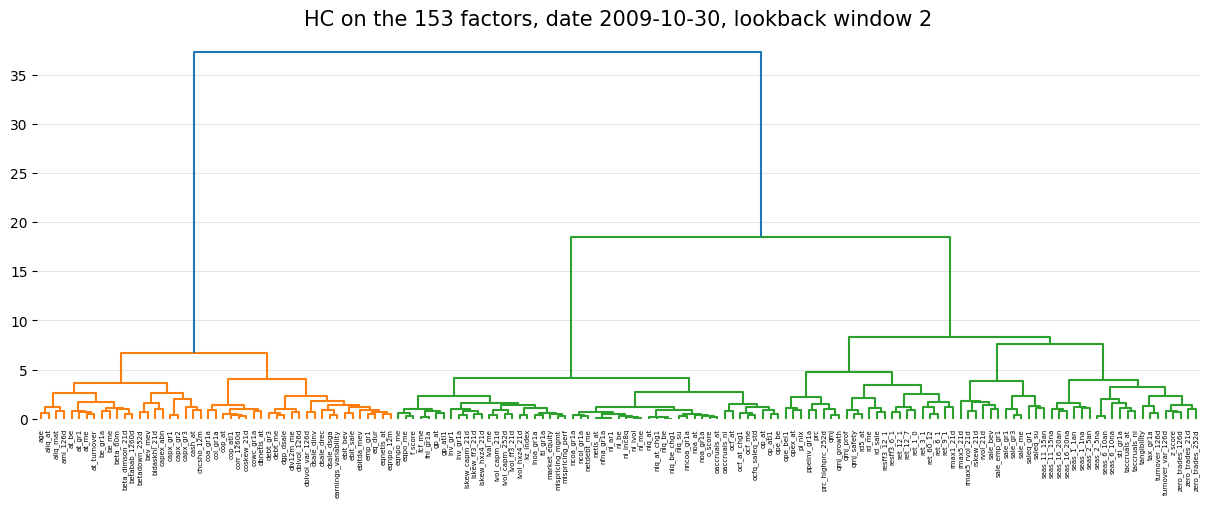

In [10]:
LABELS = df_corr_cs.columns

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))
out = dendrogram(arr_linkage_cs, labels=LABELS, ax=ax)
out_lab = ax.set_xticklabels(labels=LABELS, rotation=90)
out_title = ax.set_title(
    f"HC on the {len(LABELS)} factors, date {DATES[IDX_DATE]}, lookback window {WINDOW}", size=15
)
ax = set_layout(ax=ax)

"We observe that hierarchical clustering doesn't always group factors from the same global category together. To visualize this, let's plot each factor against its assigned cluster from the hierarchical clustering algorithm."

### PLOT LINKED GRAPH FACTORS VS CLUSTERS

In [11]:
def create_source_target_values_list(labels: list, df_source_target_value: pl.DataFrame) -> list:
    return (
        [labels.index(idx) for idx in df_source_target_value.select("factor").to_series()],
        [
            labels.index(f"Cluster {idx}")
            for idx in df_source_target_value.select("compute_cluster").to_series().to_list()
        ],
        df_source_target_value.select("nb").to_series().to_list(),
    )

In [12]:
FACTORS_CS = df_ptf_cs.select("factor").to_series().unique().sort().to_list()
PTF_CS = df_corr_cs.columns
NB_CLUSTER = len(FACTORS_CS)
CLUSTERS_CS = ["Cluster {}".format(i + 1) for i in range(NB_CLUSTER)]

df_ptf_id = pl.DataFrame({"portfolio": PTF_CS, "id": [i for i in range(1, len(PTF_CS) + 1)]})

df_clustering_idx = pl.DataFrame(
    {
        "id": [i for i in range(1, len(PTF_CS) + 1)],
        "compute_cluster": get_hc_linkage_cluster(
            arr_linkage=arr_linkage_cs, nb_cluster=NB_CLUSTER
        ),
    }
)

df_factor_id = (
    df_ptf_infos.select(["factor"])
    .unique()
    .sort("factor")
    .with_columns(pl.lit(1).alias("id_cluster"))
    .with_columns(pl.col("id_cluster").cum_sum())
)

df_out = df_ptf_id.join(df_clustering_idx, on="id", how="left").join(
    df_ptf_infos.select(["portfolio", "factor"]), on="portfolio", how="left"
)

df_source_target_value = (
    df_out.group_by(["factor", "compute_cluster"])
    .agg(pl.len().alias("nb"))
    .sort(["factor", "compute_cluster"])
    .join(df_factor_id, on="factor", how="left")
)

In [13]:
SAKEY_GRAPH_LABELS = FACTORS_CS + CLUSTERS_CS

source, target, value = create_source_target_values_list(
    labels=SAKEY_GRAPH_LABELS, df_source_target_value=df_source_target_value
)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=SAKEY_GRAPH_LABELS,
                color="blue",
            ),
            link=dict(source=source, target=target, value=value),
        )
    ]
)

fig.update_layout(title_text="Factors vs. Clusters", font_size=13)
fig.show()

We notice significant differences between the clusters generated by traditional hierarchical clustering and those identified by our algorithm. To leverage these disparities and the benefits of diversification, we propose overweighing factors from the same family that are uncorrelated with others. We will implement the Hierarchical Risk Parity approach to achieve this.